In [101]:
!pip install -U pyspark

In [102]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import desc
from pyspark.sql.functions import *
from pyspark.sql.functions import max as sparkMax
from IPython.display import display
import pyspark.sql.functions as F

#importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

import warnings; warnings.filterwarnings(action='ignore')

In [103]:
SparkSession \
  .builder \
  .master("local[*]")\
  .appName("Pyspark") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "16g") \
  .config("spark.driver.memory", "16g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","16g")\
  .getOrCreate()

In [104]:
#Creating a Spark session
mySpark = SparkSession.builder.getOrCreate()
spark = SparkSession(mySpark)

In [105]:
#loading the dataset
data = spark.read.csv("marketing/data/bank_full_raw.csv", sep = ';', inferSchema="true", header="true")

In [106]:
#Display of column name and data type
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



# 1. Exploratory Data Analysis

In [107]:
data.count()

45211

In [108]:
data.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [109]:
#Removal of rows & columns with NaN/Null values and duplicates
data.dropna()
data.dropDuplicates()
data.count()

45211

In [110]:
#check the null column count using sql
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(a) | col(a).isNull(), a)).alias(a) for a in data.columns]).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



In [111]:
df = data
df = df.replace('yes','1')
df = df.replace('no','0')
df = df.withColumn("default",df.default.cast('integer'))
df = df.withColumn("loan",df.loan.cast('integer'))
df = df.withColumn("housing",df.housing.cast('integer'))
df = df.withColumn("y",df.y.cast('integer'))

In [112]:
#Display of column name and data type
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: integer (nullable = true)



In [113]:
data.groupBy("month").count().show() 

+-----+-----+
|month|count|
+-----+-----+
|  jul| 6895|
|  jun| 5341|
|  may|13766|
|  feb| 2649|
|  oct|  738|
|  mar|  477|
|  apr| 2932|
|  dec|  214|
|  aug| 6247|
|  nov| 3970|
|  jan| 1403|
|  sep|  579|
+-----+-----+



In [114]:
data.groupBy("job").count().show() 

+-------------+-----+
|          job|count|
+-------------+-----+
|      student|  938|
|       admin.| 5171|
|      unknown|  288|
| entrepreneur| 1487|
|    housemaid| 1240|
|   unemployed| 1303|
|      retired| 2264|
|     services| 4154|
|   management| 9458|
|self-employed| 1579|
|  blue-collar| 9732|
|   technician| 7597|
+-------------+-----+



In [115]:
data.groupBy("marital").count().show()

+--------+-----+
| marital|count|
+--------+-----+
| married|27214|
|  single|12790|
|divorced| 5207|
+--------+-----+



In [116]:
data.groupBy("education").count().show() 

+---------+-----+
|education|count|
+---------+-----+
|secondary|23202|
|  unknown| 1857|
| tertiary|13301|
|  primary| 6851|
+---------+-----+



In [117]:
data.groupBy("housing").count().show()  

+-------+-----+
|housing|count|
+-------+-----+
|     no|20081|
|    yes|25130|
+-------+-----+



In [118]:
data.groupBy("loan").count().show()

+----+-----+
|loan|count|
+----+-----+
|  no|37967|
| yes| 7244|
+----+-----+



In [119]:
data.groupBy("contact").count().show()

+---------+-----+
|  contact|count|
+---------+-----+
|  unknown|13020|
| cellular|29285|
|telephone| 2906|
+---------+-----+



In [120]:
data.groupBy("campaign").count().show()

+--------+-----+
|campaign|count|
+--------+-----+
|      28|   16|
|      44|    1|
|      16|   79|
|      17|   69|
|      23|   22|
|       7|  735|
|      38|    3|
|      14|   93|
|      18|   51|
|      12|  155|
|      35|    4|
|      55|    1|
|       8|  540|
|      51|    1|
|      10|  266|
|      50|    2|
|      24|   20|
|      11|  201|
|       2|12505|
|      36|    4|
+--------+-----+
only showing top 20 rows



In [121]:
data.groupBy("poutcome").count().show()  

+--------+-----+
|poutcome|count|
+--------+-----+
| success| 1511|
| unknown|36959|
|   other| 1840|
| failure| 4901|
+--------+-----+



In [122]:
data.groupBy("y").count().show() 

+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



In [123]:
data.filter((F.col('poutcome')=='unknown'))\
    .filter(
        (F.col('y') == 'yes')
    )\
    .show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  no|unknown|  5|  may|     67

In [124]:
data.filter((F.col('poutcome')=='success'))\
    .filter(
        (F.col('y') == 'yes')
    )\
    .show()

+---+------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
| 56|  technician| married|secondary|     no|    589|    yes|  no|  unknown| 23|  oct|     518|       1|  147|       2| success|yes|
| 53|     retired| married| tertiary|     no|   2269|     no|  no| cellular| 17|  nov|    1091|       2|  150|       1| success|yes|
| 45|  management|divorced|secondary|     no|    644|    yes|  no| cellular| 19|  nov|     418|       1|  168|       1| success|yes|
| 46|  unemployed|divorced|secondary|     no|   3354|    yes|  no| cellular| 19|  nov|     522|       1|  174|       1| success|yes|
| 40|  management| married| tertiary|     no|   3352|    yes|  no| ce

In [125]:
data.filter((F.col('poutcome')=='failure'))\
    .filter(
        (F.col('y') == 'yes')
    )\
    .show()

+---+-------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|age|          job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
| 33|     services| married|secondary|     no|   3444|    yes|  no|telephone| 21|  oct|     144|       1|   91|       4| failure|yes|
| 36|   management| married| tertiary|     no|      0|    yes|  no|telephone| 23|  oct|     140|       1|  143|       3| failure|yes|
| 34|       admin.| married| tertiary|     no|    899|    yes|  no|  unknown| 12|  nov|     114|       1|  170|       3| failure|yes|
| 49|     services| married|secondary|     no|    202|    yes|  no| cellular| 17|  nov|     651|       2|  104|       1| failure|yes|
| 37|   technician| married|secondary|     no|   5115|    yes|

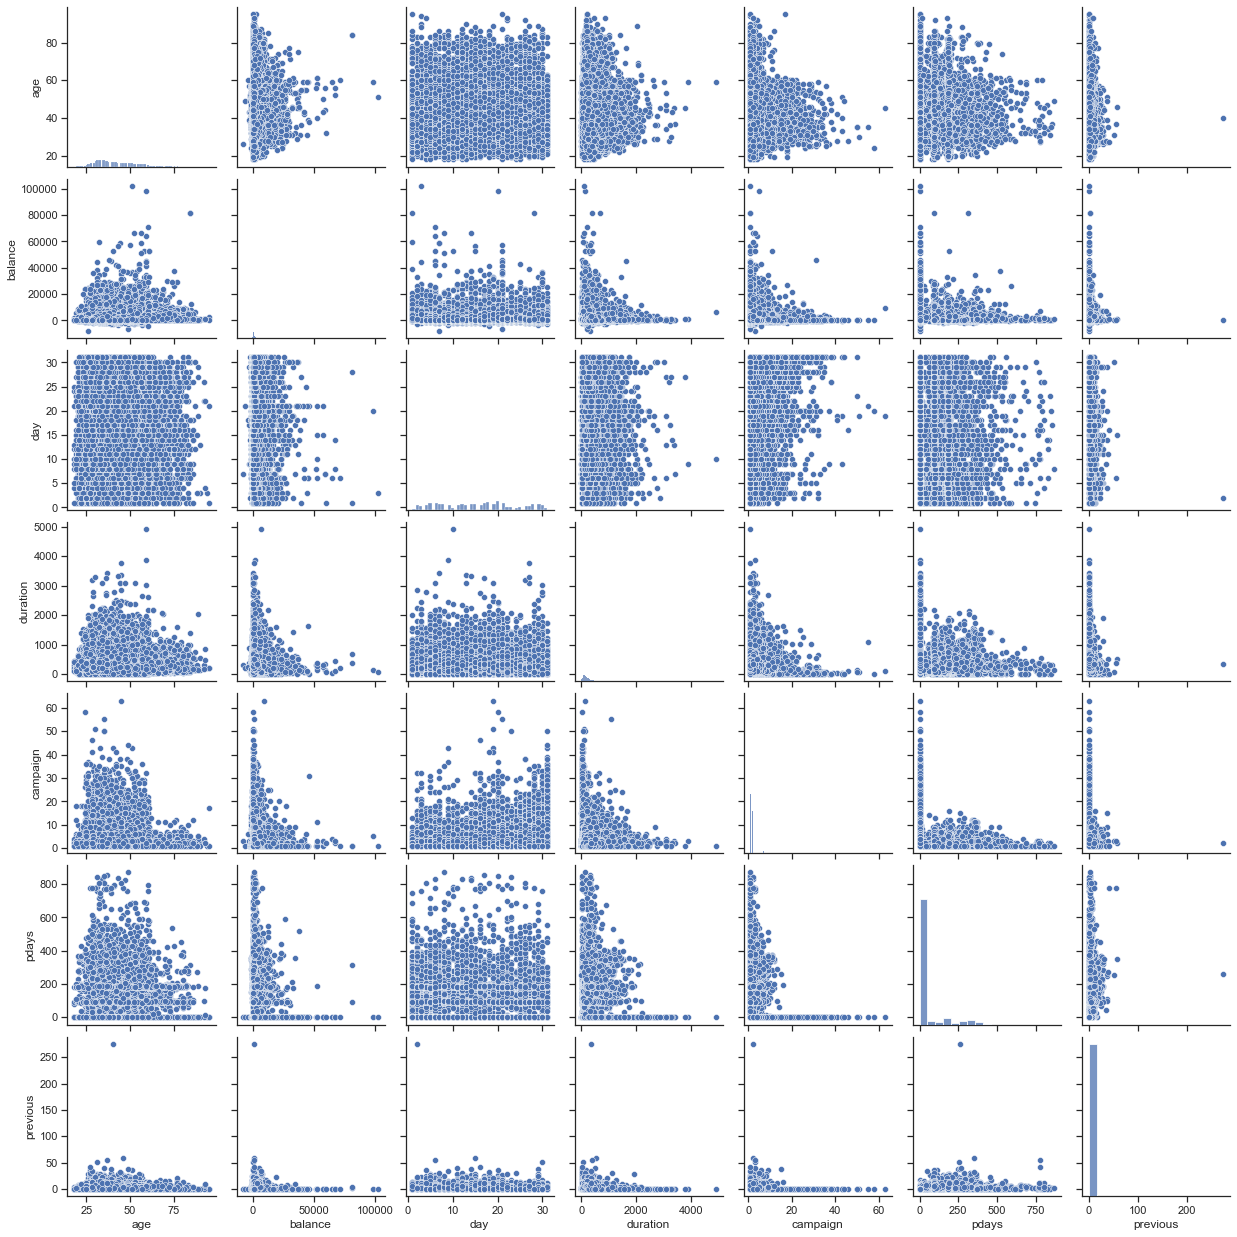

In [155]:
sns.set(style="ticks")

sns.pairplot(data.toPandas())
plt.show()

In [127]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|      0|   2143|      1|   0|unknown|  5|  may|     261|       1|   -1|       0| unknown|  0|
| 44|  technician|  single|secondary|      0|     29|      1|   0|unknown|  5|  may|     151|       1|   -1|       0| unknown|  0|
| 33|entrepreneur| married|secondary|      0|      2|      1|   1|unknown|  5|  may|      76|       1|   -1|       0| unknown|  0|
| 47| blue-collar| married|  unknown|      0|   1506|      1|   0|unknown|  5|  may|      92|       1|   -1|       0| unknown|  0|
| 33|     unknown|  single|  unknown|      0|      1|      0|   0|unknown|  5|  may

[Text(0.5, 0, 'job'), Text(0, 0.5, 'y')]

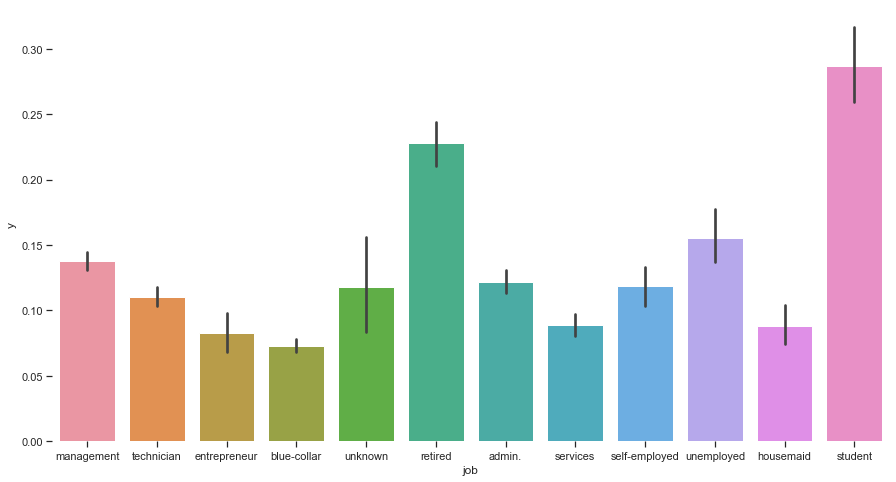

In [128]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="job", y = "y", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='job', ylabel='y')

[Text(0.5, 0, 'marital'), Text(0, 0.5, 'y')]

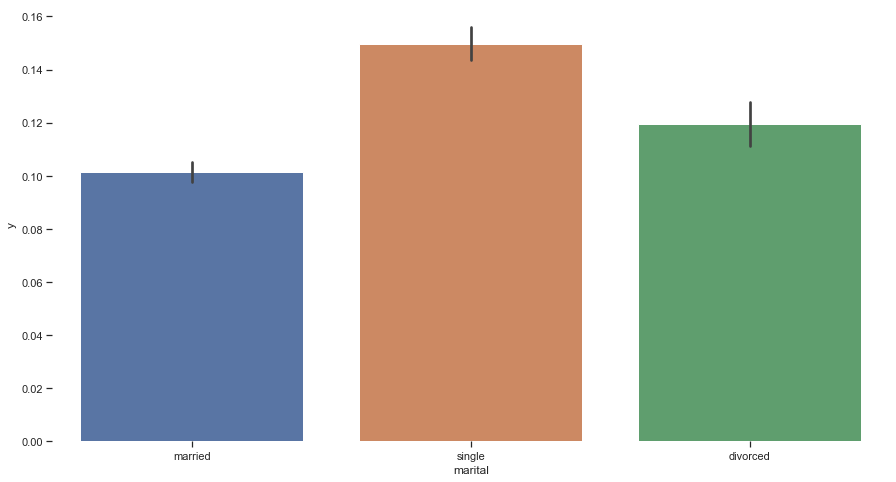

In [129]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="marital", y = "y", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='marital', ylabel='y')

[Text(0.5, 0, 'education'), Text(0, 0.5, 'y')]

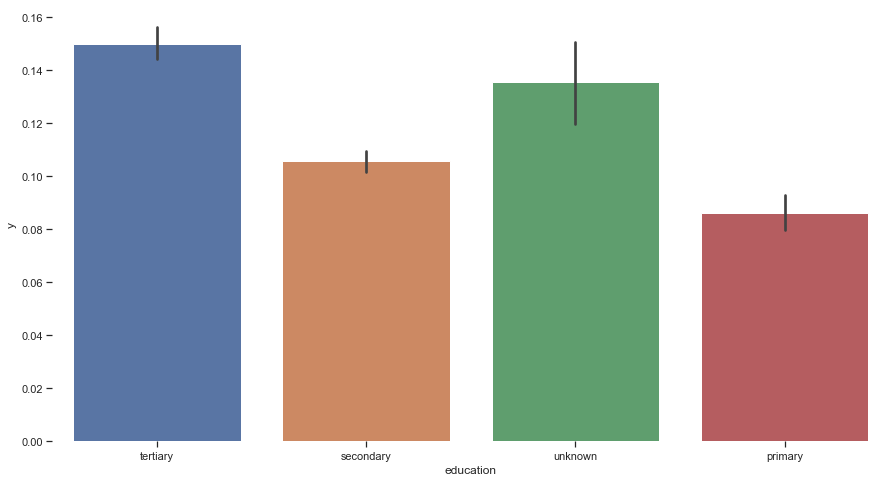

In [130]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="education", y = "y", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='education', ylabel='y')

[Text(0.5, 0, 'housing'), Text(0, 0.5, 'y')]

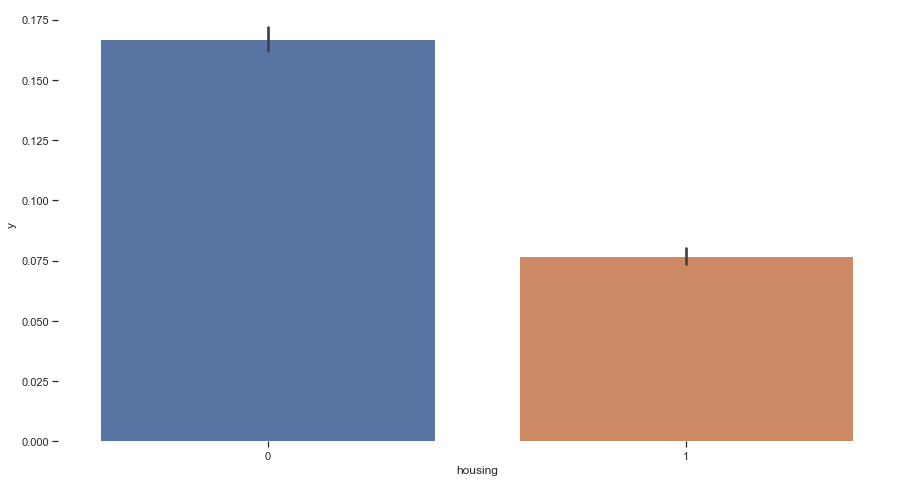

In [131]:
f, ax = plt.subplots(figsize = (15,8)) 
sns.barplot(x="housing", y = "y", data = df.toPandas())
sns.despine(left = True, bottom = True)
ax.set(xlabel='housing', ylabel='y')

# 2. Data Preperation

In [132]:
cols = df.columns

#### Encode catagorical features and transform/merge multiple columns into a vector column

In [133]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="Subscribed")
stages += [assembler]

#### Notice that the dataframe now has 2 new columns in the beginning - "label" and "Subscribed"

In [134]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'Subscribed'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- Subscribed: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: integer (nullable = true)



In [135]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
Subscribed,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,0,0,0,0,0
balance,2143,29,2,1506,1
housing,1,1,1,1,0
loan,0,0,1,0,0


#### 80/20 train/test data split 

In [136]:
train, test = df.randomSplit([0.8, 0.2], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 36117
Test Dataset Count: 9094


### Logistic Regression

In [137]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'Subscribed', labelCol = 'label', maxIter=15)
lrModel = lr.fit(train)

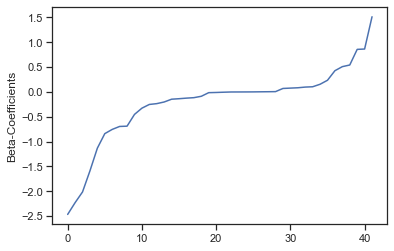

In [138]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta-Coefficients')
plt.show()

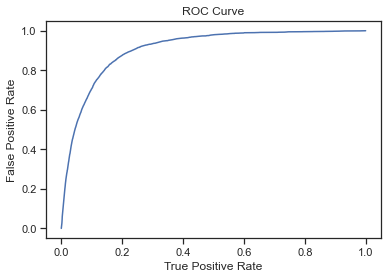

Training set areaUnderROC: 0.9078060098671566


In [139]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

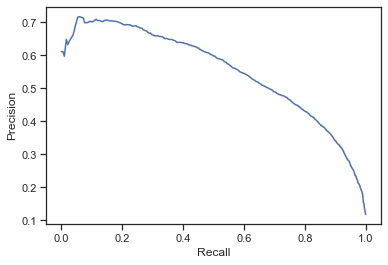

In [140]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [141]:
predictions = lrModel.transform(test)
predictions.filter((F.col('prediction') == 1.0))\
    .show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 36|blue-collar|married|secondary|      0|    195|      1|   1| cellular|  7|  may|    1297|       2|   -1|       0| unknown|  0|[-0.9819024638446...|[0.27251445639167...|       1.0|
|  0.0|(42,[0,11,13,16,1...| 27|blue-collar|married|secondary|      0|   1295|      1|   0| cellular| 14|  may|    1106|       1|   -1|       0| unknown|  0

In [142]:
predictions.filter((F.col('prediction') == 1.0))\
    .count()

581

In [143]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9072459734048652


## Decision Tree Classifier

In [144]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'Subscribed', labelCol = 'label', maxDepth= 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.filter((F.col('prediction') == 1.0))\
    .show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 36|blue-collar|married|secondary|      0|    195|      1|   1| cellular|  7|  may|    1297|       2|   -1|       0| unknown|  0|[500.0,732.0]|[0.40584415584415...|       1.0|
|  0.0|(42,[0,11,13,16,1...| 27|blue-collar|married|secondary|      0|   1295|      1|   0| cellular| 14|  may|    1106|       1|   -1|       0| unknown|  0|[500.0,732.0]|[0.4058441558

In [145]:
predictions.filter((F.col('prediction') == 1.0))\
    .count()

339

In [146]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.324123120154093


## Random Forest Classifier

In [147]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'Subscribed', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.filter((F.col('prediction') == 1.0))\
    .show()

+-----+----------+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------------+-----------+----------+
|label|Subscribed|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|rawPrediction|probability|prediction|
+-----+----------+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------------+-----------+----------+
+-----+----------+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------------+-----------+----------+



In [148]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions)))

Test Area Under ROC: 0.886395582057108


## Gradient-Boosted Tree Classifier

In [149]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'Subscribed', labelCol = 'label', maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.filter((F.col('prediction') == 1.0))\
    .show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 36|blue-collar|married|secondary|      0|    195|      1|   1|cellular|  7|  may|    1297|       2|   -1|       0| unknown|  0|[-0.1842325314295...|[0.40891196849718...|       1.0|
|  0.0|(42,[0,11,13,16,1...| 27|blue-collar|married|secondary|      0|   1295|      1|   0|cellular| 14|  may|    1106|       1|   -1|       0| unknown|  0|[-0.

In [150]:
predictions.filter((F.col('prediction') == 1.0))\
    .count()

716

In [151]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions)))

Test Area Under ROC: 0.9110134674718358


## Modifying this model with the ParamGridBuilder as well as the CrossValidator because the Logistic Regression produced the best results

In [152]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder().addGrid(lr.maxIter, [500]) \
                                .addGrid(lr.regParam, [0]) \
                                .addGrid(lr.elasticNetParam, [1]) \
                                .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9081598311098454

In [153]:
predictions.show()

+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|label|          Subscribed|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|       rawPrediction|         probability|prediction|
+-----+--------------------+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+--------------------+--------------------+----------+
|  0.0|(42,[0,11,13,16,1...| 48|blue-collar|married|secondary|      1|      0|      1|   1|cellular|  7|  may|     275|       1|   -1|       0| unknown|  0|[3.25026802136608...|[0.96268274243176...|       0.0|
|  0.0|(42,[0,11,13,16,1...| 30|blue-collar|married|secondary|      0|   -109|      1|   1|cellular|  7|  may|     160|       4|   -1|       0| unknown|  0|[4.0

In [154]:
predictions.count()

9094